In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# from torch.autograd.functional import jvp
# def _push_forward(f, x, V, dt):
#     cols = []
#     for j in range(V.shape[1]):
#         _, jv = jvp(f, x, V[:, j], create_graph=False)
#         cols.append(V[:, j] + dt * jv)
#     return torch.stack(cols, dim=1)

from torch.func import jvp, vmap
def _push_forward(f, x: torch.Tensor, V: torch.Tensor, dt):
    def inner(v_col):
        # Single-direction JVP: returns only the JVP, we ignore primal_out.
        _, jv = jvp(f, (x,), (v_col,))
        return v_col + dt * jv          # n-vector

    # V.T has shape (k, n)  |→  k independent JVPs in parallel
    return vmap(inner)(V.T).T           # back to (n, k)


def run_lyapunov(f, x0, V0, dt, steps, *, hold_at_origin=False, clv_steps=1000, return_vectors=False):
    x = x0.clone().detach()
    V = V0.clone().detach()  # current GS basis  (k columns)
    k = V.shape[1]

    S = torch.zeros((steps, k), dtype=torch.float64, device=x.device)  # log diag(R)
    Rs = []  # store QR data

    x_m = torch.zeros_like(x0)
    V_m = torch.zeros_like(V0)
    m = steps - clv_steps - 1

    if hold_at_origin:
        h = int(np.sqrt(x.shape[0]).round())
        i, j = torch.meshgrid(
            torch.arange(h, device=x.device),
            torch.arange(h, device=x.device),
            indexing="ij",
        )
        i_idx, j_idx = i.flatten(), j.flatten()

    # ---------- forward QR pass ----------
    for n in tqdm(range(steps), leave=False, desc="forward"):
        # optional translation of origin
        if hold_at_origin:
            sA = torch.sum(x) + 1e-30
            mi = torch.sum(i_idx * x) / sA
            mj = torch.sum(j_idx * x) / sA
            sh = [h // 2 - int(mi), h // 2 - int(mj)]
            x = torch.roll(x.reshape(h, h), sh, (0, 1)).flatten()
            V = torch.roll(V.reshape(h, h, -1), sh, (0, 1)).reshape_as(V)
        
        # --- push tangent basis forward ---
        # x.requires_grad_(True)
        W = _push_forward(f, x, V, dt)
        # x = x.detach()

        # --- QR orthonormalisation ---
        Q, R = torch.linalg.qr(W, mode="reduced")
        V = Q  # next GS basis
        
        # --- integrate the state ---
        x = x + dt * f(x)

        if n == m:
            x_m = x.clone()
            V_m = V.clone()
        if n > m:
            Rs.append(R)

        S[n] = torch.log(torch.abs(torch.diagonal(R)))

    # ---------- Lyapunov exponents ----------
    half = steps // 2
    cum = S.cumsum(0)
    counts = torch.arange(1, steps + 1, device=S.device, dtype=S.dtype).unsqueeze(1)
    lambda_history = cum / (counts * dt)
    lambda_history[half:] = (cum[half:] - cum[:-half]) / (half * dt)

    lambdas = lambda_history[-1]
    order = torch.argsort(lambdas, descending=True)

    results = [lambdas[order], lambda_history[:,order], x_m]
    if return_vectors:
        # ---------- GS orthonormal basis ----------
        GSV_m = V_m.clone()  # GS basis at final step

        # ---------- CLV reconstruction  ----------
        C = torch.eye(k, dtype=torch.float64, device=x.device)   # start at t_m
        for i, R in enumerate(reversed(Rs)):
            C = torch.linalg.solve_triangular(R, C, upper=True)  # C <- R^{-1}C
            if i % 100 == 0:
                C = C / torch.linalg.norm(C, dim=0, keepdim=True)  # normalise

        CLV_m = (GSV_m @ C)[:, order].clone()  # CLVs at final step
        CLV_m = CLV_m / torch.linalg.norm(CLV_m, dim=0, keepdim=True)


        results.append(GSV_m[:,order]) # GSV basis at m_th step
        results.append(CLV_m[:,order]) # CLV basis at m_th step

    return tuple(results)


def KY_dim(lam):
    lam = np.where(np.abs(lam) < 1e-3, 0.0, lam)
    lam = np.sort(np.asarray(lam))[::-1]
    c = np.cumsum(lam)
    if np.all(c >= 0):
        return float(len(lam))
    j = np.where(c >= 0)[0][-1]
    return (j + 1) + c[j] / abs(lam[j + 1])


In [4]:
def lorenz(x):
    return torch.stack([10*(x[1]-x[0]), x[0]*(28-x[2])-x[1], x[0]*x[1]-8/3*x[2]])

x0 = torch.tensor([1.,1.,1.], dtype=torch.float64, requires_grad=True)
for _ in range(1000):
    x0 = x0 + 0.01*lorenz(x0)
    x0 = x0.detach().requires_grad_(True)
k = 3
n = x0.numel()
V0 = torch.randn(n, k, dtype=torch.float64)
Q, _ = torch.linalg.qr(V0)
V0 = Q
dt = 0.01
steps = 10000
exps = run_lyapunov(lorenz, x0, V0, dt, steps)
print(exps)

100%|██████████| 10000/10000 [00:28<00:00, 353.14it/s]

(tensor([  1.0470,  -0.0349, -14.9781], dtype=torch.float64), tensor([[-0.0466,  0.0072, -0.0932],
        [-0.0383,  0.0047, -0.0999],
        [-0.0292,  0.0012, -0.1062],
        ...,
        [ 0.0325, -0.0123, -0.1574],
        [ 0.0296, -0.0096, -0.1568],
        [ 0.0262, -0.0065, -0.1561]], dtype=torch.float64))


In [165]:
scale = 3
H, W = (256, 256)
# params = {"R":18,"T":10,"b":[1,1/2,1/2,1],"m":0.24,"s":0.02,"kn":1,"gn":1} # soliton
# params = {"R":18,"T":10,"b":[1,1/2,1/2,1],"m":0.2,"s":0.013,"kn":1,"gn":1} # periodic
# params = {"R":18,"T":10,"b":[1,0.01,0.25,1],"m":0.175,"s":0.0135,"kn":1,"gn":1} # chaotic
params = {"R":18,"T":10,"b":[1,0.01,0.5,1],"m":0.22,"s":0.026,"kn":1,"gn":1} # chaotic

def poly_kernel(r):
    return (4*r*(1-r))**4


def build_kernel(b, R, H):
    B = np.array(b.size)
    mid = H // 2
    Dx, Dy = np.meshgrid(np.arange(-mid, mid), np.arange(-mid, mid), indexing='ij')
    D = np.sqrt(Dx**2 + Dy**2) / R * B

    K = (D<B) * poly_kernel(D % 1) * b[np.minimum(D.astype(np.int64), B-1)]
    K = K / np.sum(K)
    K_fft = np.fft.fft2(np.fft.fftshift(K))
    return K_fft


b = np.array(params['b'])
R = params['R'] * scale
m = params['m']
s = params['s']
T = params['T']

K_fft = build_kernel(b, R, H)

device='cuda'
K_fft = torch.tensor(K_fft, dtype=torch.complex64).to(device)
m = torch.tensor(m, dtype=torch.float32).to(device)
s = torch.tensor(s, dtype=torch.float32).to(device)

def step_growth(A,m=m,s=s):
    U = torch.fft.ifft2(torch.fft.fft2(A) * K_fft).real
    mask = (U >= m-s) & (U <= m+s)
    zero = torch.tensor(0.0).to(device)
    one = torch.tensor(1.0).to(device)
    G = torch.where(mask, one, zero)
    return G

@torch.jit.script
def bell_growth(U,m=m,s=s):
    G = torch.exp(-((U-m)/s)**2 / 2 )* 2 - 1
    return (G+1)/2

def bell_growth_prime(U,m=m,s=s):
    return -(U-m)/s**2 * torch.exp(-((U-m)/s)**2 / 2)

def bell_growth_second(U,m=m,s=s):
    return ((U-m)**2-s**2) * torch.exp(-((U-m)/s)**2 / 2) / s**4

def bell_growth_third(U,m=m,s=s):
    return -(U-m)*((U-m)**2-3*s**2) * torch.exp(-((U-m)/s)**2 / 2) / s**6

def poly_growth(U,m=m,s=s):
    G = torch.maximum(torch.tensor(0), 1 - ((U-m)/s)**2 / 9 )**4 * 2 - 1
    return (G+1)/2

def poly_growth_prime(U, m, s):
    alpha = 1 - ((U - m) / s)**2 / 9
    return -8 * (U - m) / (9 * s**2) * alpha.clamp(min=0)**3

def convK(A, K_fft=K_fft):
    return torch.fft.ifft2(torch.fft.fft2(A) * K_fft).real

In [166]:
def square_init(h,w):
    A = torch.zeros(H, W).to(device)
    rnd = torch.ones(h, w).to(device)
    hmid = H // 2
    wmid = W // 2
    A[hmid-h//2:hmid+h//2, wmid-w//2:wmid+w//2] = rnd
    return A

def random_square_init(h,w,m,s):
    A = torch.zeros(H, W).to(device)
    rnd = torch.rand(h, w).to(device) * s + m
    hmid = H // 2
    wmid = W // 2
    A[hmid-h//2:hmid+h//2, wmid-w//2:wmid+w//2] = rnd
    return A

def bell_init(radius):
    s = radius / 3
    A = torch.zeros(H, W).to(device)
    if radius <= 0:
        return A
    i, j = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    i, j = i.to(device), j.to(device)
    A = torch.exp(-((i-H//2)**2 + (j-W//2)**2) / (2*s**2)) * 2 - 1
    return (A+1)/2

def com(A):
    device = 'cuda'
    H, W = A.shape[-2:]
    i, j = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    i, j = i.to(device), j.to(device)
    sA = torch.sum(A, dim=(-2,-1)) + 1e-8
    mi = torch.sum(i * A ,dim=(-2,-1)) / sA
    mj = torch.sum(j * A, dim=(-2,-1)) / sA
    return mi, mj

@torch.jit.script
def com_vel(A1,m=m,s=s):
    dt = 1/100
    A2 = A1 + (bell_growth(convK(A1),m=m,s=s) - A1) * dt
    mi1, mj1 = com(A1)
    mi2, mj2 = com(A2)
    return (mi2 - mi1)/dt, (mj2 - mj1)/dt

@torch.jit.script
def lstsq_vel(A,m=m,s=s):
    grad = torch.stack(torch.gradient(A), dim=2)
    dAdt = bell_growth(convK(A),m=m,s=s) - A

    A = grad.reshape(-1, 2)
    B = torch.flatten(dAdt)

    v = torch.linalg.lstsq(A, B).solution
    return v

@torch.jit.script
def simulate(A, steps:int, m=m, s=s, hold_at_origin:bool =False):
    device = 'cuda'
    H, W = A.shape[-2:]
    T = torch.tensor(10., device=device)
    for _ in range(steps):
        A = A + (poly_growth(convK(A),m=m,s=s) - A)/T
        if hold_at_origin:
            mi, mj = com(A)
            A = torch.roll(A, [H//2 - int(mi), W//2 - int(mj)], dims=(0, 1))
    return A

In [ ]:
A_glider_zoom = torch.zeros(H, W).to(device)


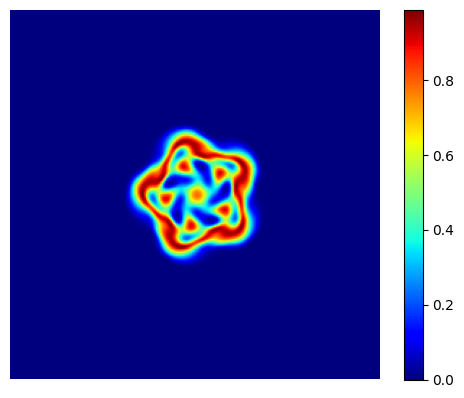

In [181]:
# A_ = bell_init(int(32*scale))+ random_square_init(int(32*scale), int(32*scale), 0, 0.001)
# A_ = bell_init(int(32*scale))+ random_square_init(int(32*scale), int(32*scale), 0, 0.1) # chaotic
# A_ = bell_init(int(42*scale))+ random_square_init(int(45*scale), int(45*scale), 0, 0.1)
# A_ = A_glider.clone()

_m = m.clone()
_s = s.clone()
with torch.no_grad():
    A_ = simulate(A_, 10000, m=_m, s=_s, hold_at_origin=True)

A_glider = A_.clone()

plt.imshow(A_.cpu().detach().numpy(), cmap='jet')
plt.colorbar()
plt.axis('off');

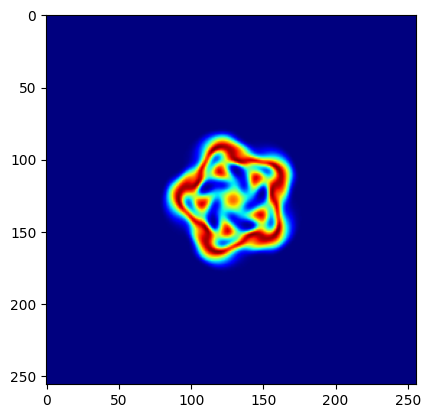

In [183]:
# np.save('rotator.npy', A_glider.cpu().detach().numpy())
A_glider = torch.tensor(np.load('rotator.npy'), dtype=torch.float32).to(device)
plt.imshow(A_glider.cpu().detach().numpy(), cmap='jet')

forward:   0%|          | 15/100000 [00:00<11:16, 147.84it/s]

[ 1.46894725e-06  1.44013670e-06  2.38433166e-09 -5.04932325e-03
 -5.04932686e-03 -3.79309680e-02 -3.79309689e-02 -5.74839901e-02
 -5.74839901e-02 -1.34482442e-01]


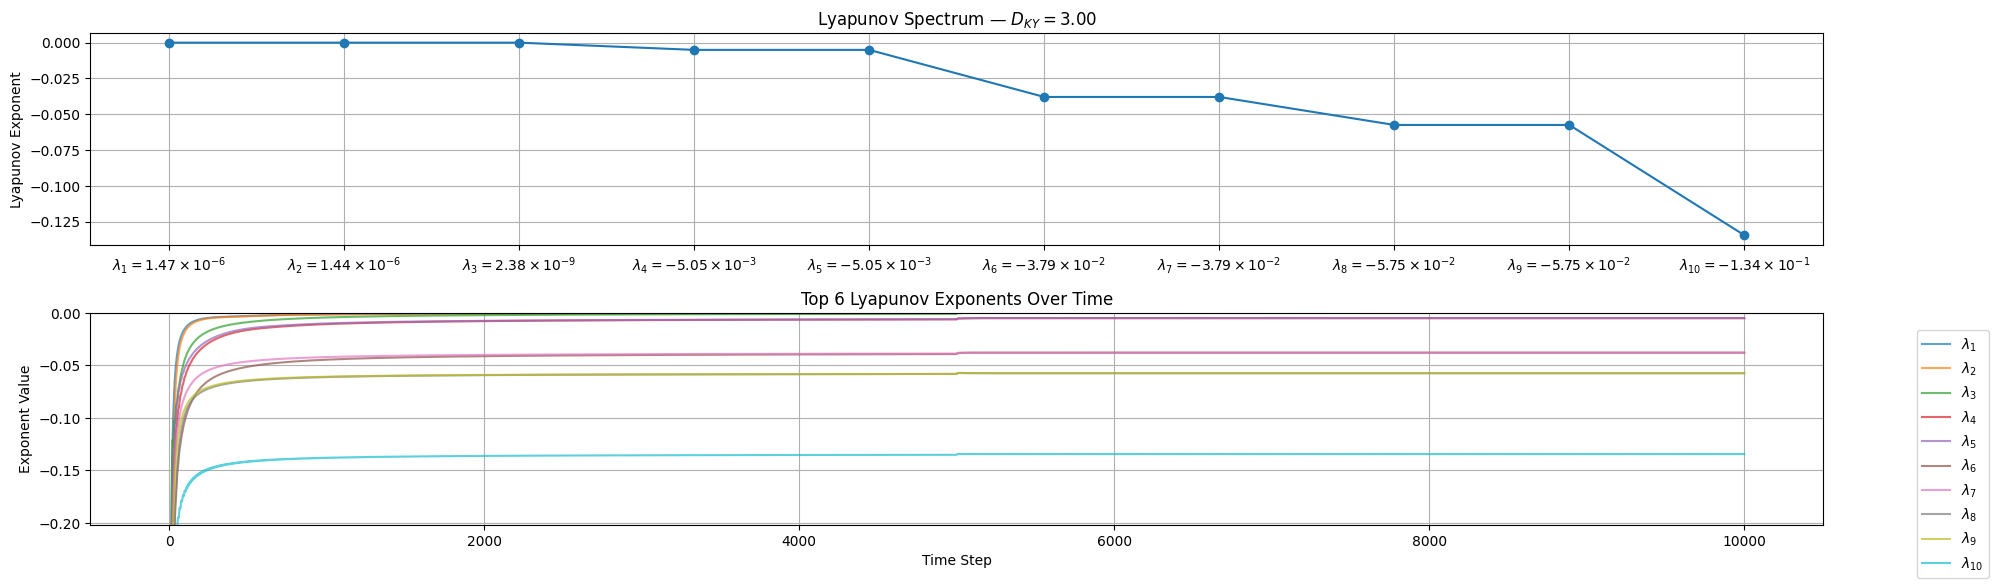

In [184]:
def lenia_step(X):
    A = X.reshape(H, W)
    return (poly_growth(convK(A),m=m,s=s) - A).flatten()

k = 10
H, W = A_glider.shape
X0 = A_glider.flatten().cuda()
V0 = torch.randn(X0.numel(), k, dtype=torch.float64)
Q, _ = torch.linalg.qr(V0)
V0 = Q.cuda()
dt = 0.1

lyapunov_exponents, histories, A_final = run_lyapunov(lenia_step, X0, V0, dt, 100000, clv_steps=5000, hold_at_origin=True, return_vectors=False)
# lyapunov_exponents, histories, A_final, GS, CLV = run_lyapunov(lenia_step, X0, V0, dt, 100000, clv_steps=5000, hold_at_origin=True, return_vectors=True)
lyapunov_exponents = lyapunov_exponents.cpu().detach().numpy()
histories = histories.cpu().detach().numpy()
print(lyapunov_exponents)


D_KY = KY_dim(lyapunov_exponents)
plt.figure(figsize=(20, 6))
plt.subplot(2, 1, 1)
plt.plot(np.arange(k)+1, lyapunov_exponents, 'o-')
labels = []
for i, v in enumerate(lyapunov_exponents):
    mantissa, exponent = f"{v:.2e}".split('e')
    labels.append(f"$\\lambda_{{{i+1}}}={mantissa}\\times10^{{{int(exponent)}}}$")
plt.xticks(np.arange(k) + 1, labels, rotation=0)
plt.ylabel('Lyapunov Exponent')
plt.title('Lyapunov Spectrum — $D_{KY} ='+' {:.2f}$'.format(D_KY))
plt.grid(True, which='both')
plt.subplot(2, 1, 2)
cmap = plt.cm.tab10
colors = cmap(np.linspace(0, 1, histories.shape[1]))
for i in range(histories.shape[1]):
    plt.plot(histories[::10, i], color=colors[i], alpha=0.7, label='$\lambda_{'+str(i+1)+'}$')
lmin = lyapunov_exponents[-1] * 1.5
lmax = lyapunov_exponents[0] * 1.5
plt.ylim(lmin, lmax)
plt.xlabel('Time Step')
plt.ylabel('Exponent Value')
plt.title('Top 6 Lyapunov Exponents Over Time')
plt.legend(bbox_to_anchor=(1.05, 0.95), loc='upper left')
plt.grid(True)

plt.tight_layout()

In [122]:
np.savetxt('glider_periodic_le.txt', lyapunov_exponents)

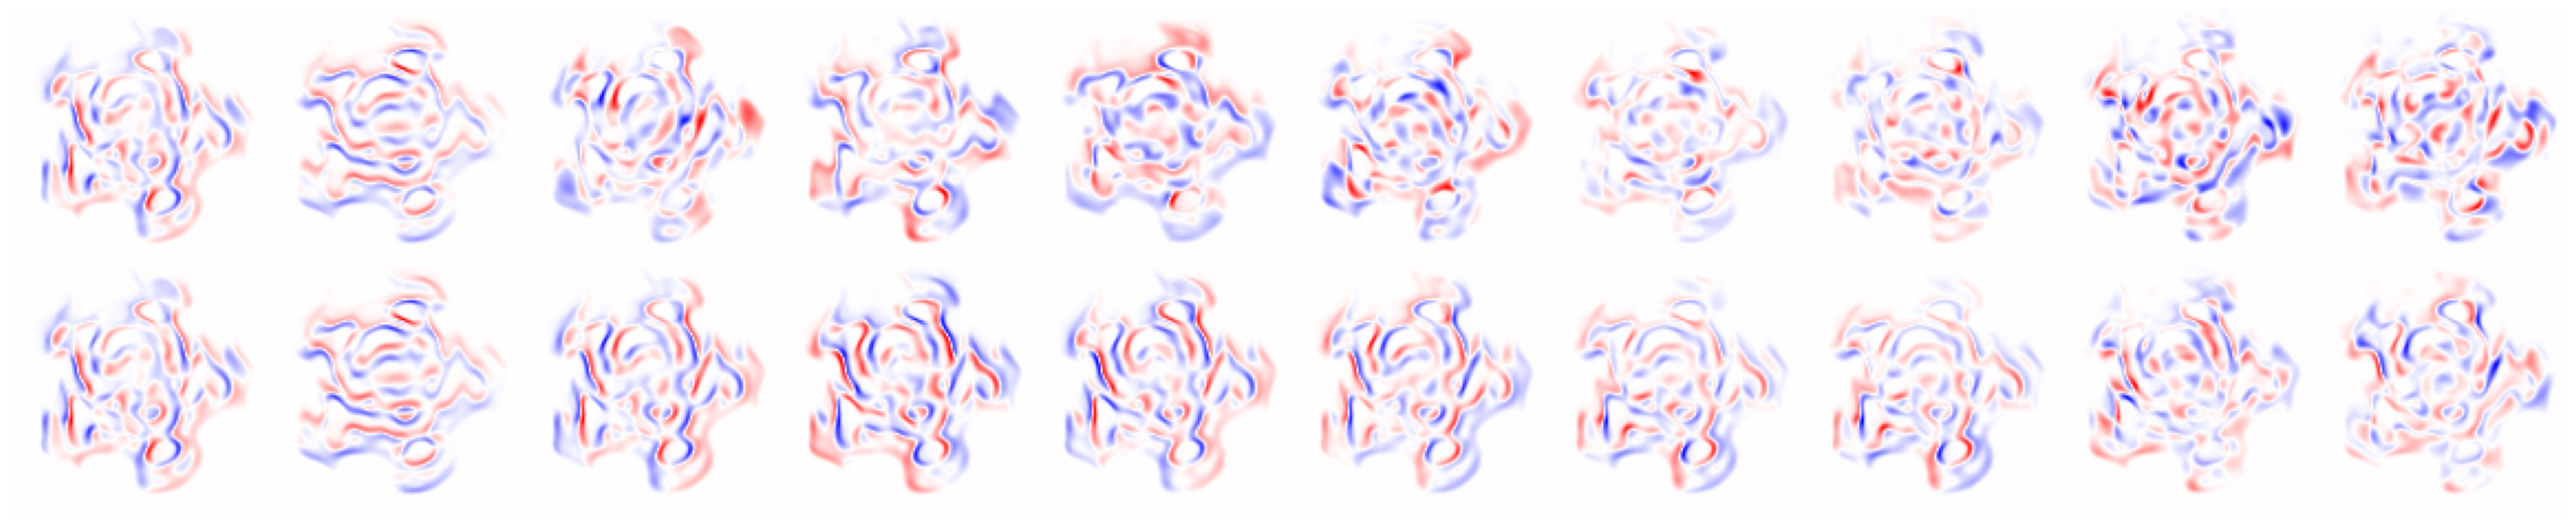

In [96]:
clvs = CLV.reshape(H,W,-1).cpu().detach().numpy()
gs = GS.reshape(H,W,-1).cpu().detach().numpy()
plt.figure(figsize=(30, 6))

for i in range(k):
    plt.subplot(2, k, i+1)
    vector = gs[..., i]
    max_abs_val = np.max(np.abs(vector))
    plt.imshow(vector[70:-70,70:-70], cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
    # plt.title(f'{i+1}st Gram-Schmidt Vector')
    plt.axis('off')
    
    plt.subplot(2, k, i+1+k)
    vector = clvs[..., i]
    max_abs_val = np.max(np.abs(vector))
    plt.imshow(vector[70:-70,70:-70], cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
    # plt.title(f'{i+1}st Covariant Lyapunov Vector')
    plt.axis('off')

plt.tight_layout(pad=0)


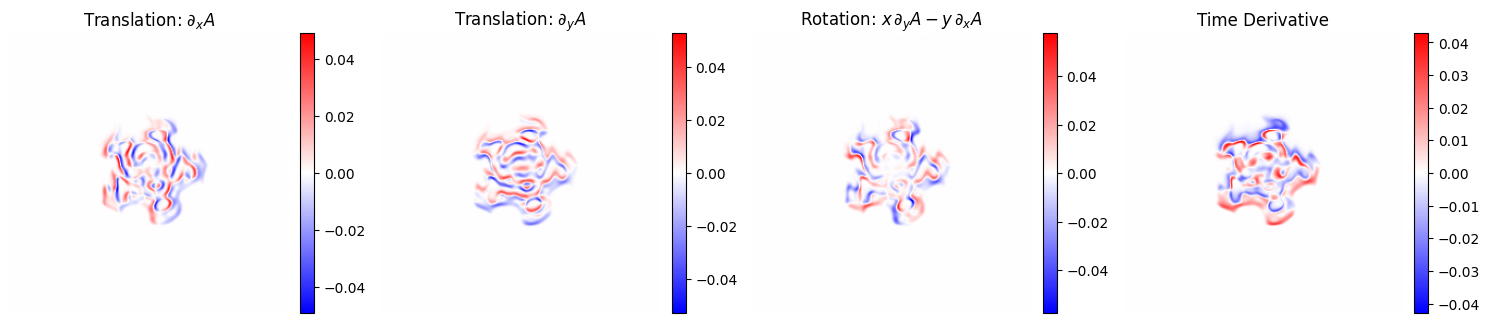

In [97]:
# Reshape to 2D numpy
A = A_final.reshape(256, 256).cpu().detach().numpy()

# First derivatives
gradient_x = np.gradient(A, axis=1)
gradient_y = np.gradient(A, axis=0)
gradient_x = gradient_x / np.linalg.norm(gradient_x)
gradient_y = gradient_y / np.linalg.norm(gradient_y)

# Directional gradient helper
def directional_gradient(grad_x, grad_y, theta_deg):
    theta = np.radians(theta_deg)
    return grad_x * np.cos(theta) + grad_y * np.sin(theta)

# Build centered coordinate grid for rotation
h, w = A.shape  
y_inds, x_inds = np.indices((h, w))
x_center = (w - 1) / 2
y_center = (h - 1) / 2
X = x_inds - x_center
Y = y_inds - y_center

# Rotational generator: x ∂y A - y ∂x A
rotational = X * gradient_y - Y * gradient_x
rotational = rotational / np.linalg.norm(rotational)

# Calculate time derivative: poly_growth(convK(A)) - A
time_derivative = poly_growth(convK(A_final.reshape(256,256))).cpu().numpy() - A
time_derivative = time_derivative / np.linalg.norm(time_derivative)

# Plot all four generators
plt.figure(figsize=(15, 5))

# 1) ∂/∂x direction
plt.subplot(1, 4, 1)
m1 = np.max(np.abs(gradient_x))
plt.imshow(gradient_x, cmap='bwr', vmin=-m1, vmax=m1)
plt.title(f'Translation: $∂_xA$')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')

# 2) ∂/∂y direction
plt.subplot(1, 4, 2)
m2 = np.max(np.abs(gradient_y))
plt.imshow(gradient_y, cmap='bwr', vmin=-m2, vmax=m2)
plt.title(f'Translation: $∂_yA$')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')

# 3) Rotational generator
plt.subplot(1, 4, 3)
m3 = np.max(np.abs(rotational))
plt.imshow(rotational, cmap='bwr', vmin=-m3, vmax=m3)
plt.title('Rotation: $x\,∂_yA - y\,∂_xA$')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')

# 4) Time derivative
plt.subplot(1, 4, 4)
m4 = np.max(np.abs(time_derivative))
plt.imshow(time_derivative, cmap='bwr', vmin=-m4, vmax=m4)
plt.title('Time Derivative')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')

plt.tight_layout()
plt.show()


In [84]:
np.tensordot(gs[...,0], gs[...,])

array([ 1.00000000e+00, -1.56125113e-17, -4.51028104e-17,  9.31329666e-17,
       -4.48859699e-17, -1.88922229e-16,  1.74556550e-17,  2.68882139e-17,
        1.47451495e-17,  4.33680869e-18])

In [43]:
np.dot(clvs[...,6].flatten(), gradient_x.flatten())/np.linalg.norm(gradient_x.flatten())

np.float64(-0.7791492185118593)

In [98]:
clvs_basis = clvs[...,2:6].reshape(-1, 4)

generators = np.stack([gradient_x.flatten(), gradient_y.flatten(), rotational.flatten(), time_derivative.flatten()], axis=1)

Qclv, _ = np.linalg.qr(clvs_basis, mode='reduced')
Qgen, _ = np.linalg.qr(generators, mode='reduced')

C = Qclv.T @ Qgen
sigma = np.linalg.svd(C, compute_uv=False)
sigma = np.clip(sigma, -1.0, 1.0)
theta = np.arccos(sigma)
print("principal angles (rad):", theta)
print("principal angles (deg):", np.degrees(theta))



principal angles (rad): [0.0644445  0.0956701  0.11579664 0.15468561]
principal angles (deg): [3.69239774 5.48149272 6.63465859 8.86283269]


In [83]:
CLV_pos = clvs[..., 2:6].reshape(-1, 4)
dot = CLV_pos.T @ generators

# column-wise Euclidean norms
v_norm = np.linalg.norm(CLV_pos, axis=0)        # shape (2,)
g_norm = np.linalg.norm(generators, axis=0)        # shape (4,)

# matrix of cosines |vᵢ·gⱼ| / (‖vᵢ‖‖gⱼ‖)
cosines = np.abs(dot) / (v_norm[:, None] * g_norm)

# clip for numeric safety, then angles in degrees
angles = np.rad2deg(np.arccos(np.clip(cosines, -1.0, 1.0)))
print(angles)          # expect ≈ 90° for every entry

[[18.70577758 66.03127913 78.94005728 50.01297092]
 [63.27525311 50.3519425  79.25304078 77.93941544]
 [60.46415688 37.33656757 87.74548211 72.13156503]
 [56.06863912 41.13310323 89.61606338 73.13587728]]


In [52]:
clvs_basis.shape

(65536, 4)

rank of M_ij: 4


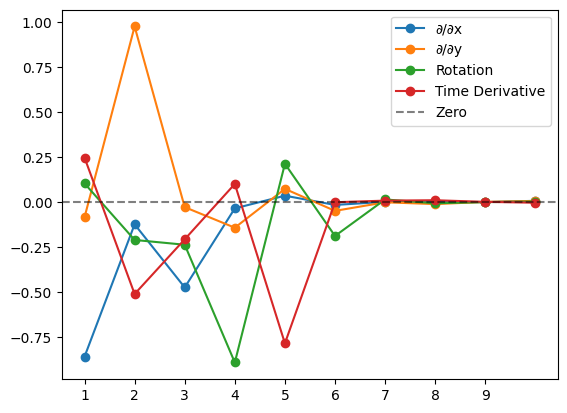

In [99]:
plt.xticks(np.arange(k))
dx_dot_gs = (gradient_x[...,None] * gs).sum((0,1))
dy_dot_gs = (gradient_y[...,None] * gs).sum((0,1))
rot_dot_gs = (rotational[...,None] * gs).sum((0,1))
dt_dot_gs = (time_derivative[...,None] * gs).sum((0,1))
plt.plot(np.arange(k)+1, dx_dot_gs, 'o-')
plt.plot(np.arange(k)+1, dy_dot_gs, 'o-')
plt.plot(np.arange(k)+1, rot_dot_gs, 'o-')
plt.plot(np.arange(k)+1, dt_dot_gs, 'o-')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.legend(['∂/∂x', '∂/∂y', 'Rotation', 'Time Derivative', 'Zero'])

dx_dot_gs = (gradient_x[...,None] * gs).sum((0,1))
dy_dot_gs = (gradient_y[...,None] * gs).sum((0,1))
rot_dot_gs = (rotational[...,None] * gs).sum((0,1))
dt_dot_gs = (time_derivative[...,None] * gs).sum((0,1))
M_ij = np.stack([dx_dot_gs[2:6], dy_dot_gs[2:6], rot_dot_gs[2:6], dt_dot_gs[2:6]], axis=1)
print('rank of M_ij:', np.linalg.matrix_rank(M_ij))